In [2]:
%set_env OMP_NUM_THREADS=1

import numpy as np
import matplotlib.pyplot as plt
import dedalus
import dedalus.public as d3
import logging
import h5py
import os
logger = logging.getLogger(__name__)

import warnings
warnings.filterwarnings('ignore')

env: OMP_NUM_THREADS=1


# Simulation of the WT case and comparisons

In [3]:
from dedalus_sims import run_and_save

initial_conditions = np.load('initial_conditions.npz')
tt = 0
t0 = initial_conditions['t0']
m0 = initial_conditions['m0'][tt, ..., 20:-20] #Crop AP poles
c0 = initial_conditions['c0'][tt, ..., 20:-20].squeeze()

# Full model with eCadherin case
params = dict(
    Lx=452., Ly=533.,   #Units of microns
    Nx=256, Ny=256,     #Not equal to check transpose
    max_time=30, timestep=0.1, save_every=5,
    mu=1., α = .25, # Flow parameters
    τ = 3, km=-0.6, # Linear term
    A = -0.66, # Quadratic term
    C = 0.5, kE = 0.25, # Mechanical feedback
)

# run_and_save(params, 'PatternedControl', logger, m0=m0, c0=c0)

# To simulate Toll RM9/Spz, flatten the initial control pattern
# c0 = 0.1 * (c0 - np.mean(c0)) + np.mean(c0)
# run_and_save(params, 'FlattenedControl', logger, m0=m0, c0=c0)

# To simulate the injection experiments, reverse the initial condition
# This can be done by a periodic shift so that ventral is dorsal and vice versa
c0 = np.roll(c0, c0.shape[0]//2, axis=0)
run_and_save(params, 'ReversedControl', logger, m0=m0, c0=c0)

2024-10-03 12:49:43,612 subsystems 0/1 INFO :: Building subproblem matrices 1/128 (~1%) Elapsed: 0s, Remaining: 4s, Rate: 3.6e+01/s
2024-10-03 12:49:43,796 subsystems 0/1 INFO :: Building subproblem matrices 13/128 (~10%) Elapsed: 0s, Remaining: 2s, Rate: 6.2e+01/s
2024-10-03 12:49:43,989 subsystems 0/1 INFO :: Building subproblem matrices 26/128 (~20%) Elapsed: 0s, Remaining: 2s, Rate: 6.4e+01/s
2024-10-03 12:49:44,186 subsystems 0/1 INFO :: Building subproblem matrices 39/128 (~30%) Elapsed: 1s, Remaining: 1s, Rate: 6.5e+01/s
2024-10-03 12:49:44,382 subsystems 0/1 INFO :: Building subproblem matrices 52/128 (~41%) Elapsed: 1s, Remaining: 1s, Rate: 6.5e+01/s
2024-10-03 12:49:44,579 subsystems 0/1 INFO :: Building subproblem matrices 65/128 (~51%) Elapsed: 1s, Remaining: 1s, Rate: 6.5e+01/s
2024-10-03 12:49:44,774 subsystems 0/1 INFO :: Building subproblem matrices 78/128 (~61%) Elapsed: 1s, Remaining: 1s, Rate: 6.6e+01/s
2024-10-03 12:49:44,969 subsystems 0/1 INFO :: Building subprobl

# Plot the comparison

0.0019594053380284325
(57, 256, 256)
0.0008168459129980147
(57, 256, 256)
0.0015937665413819305
(57, 256, 256)


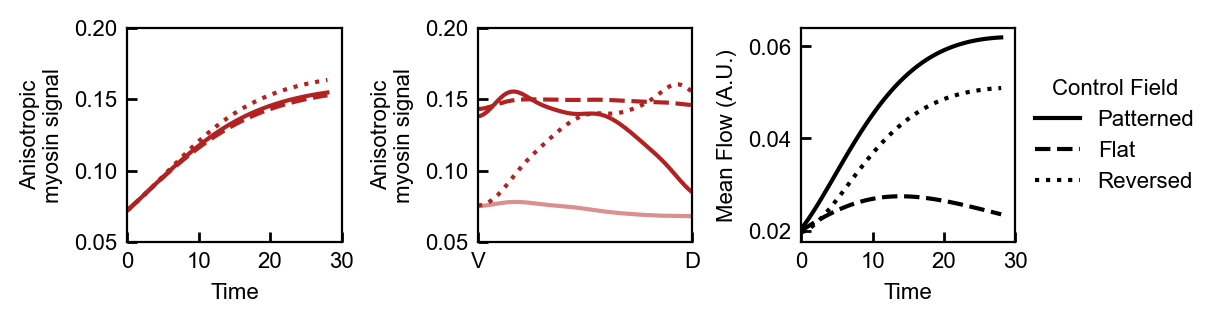

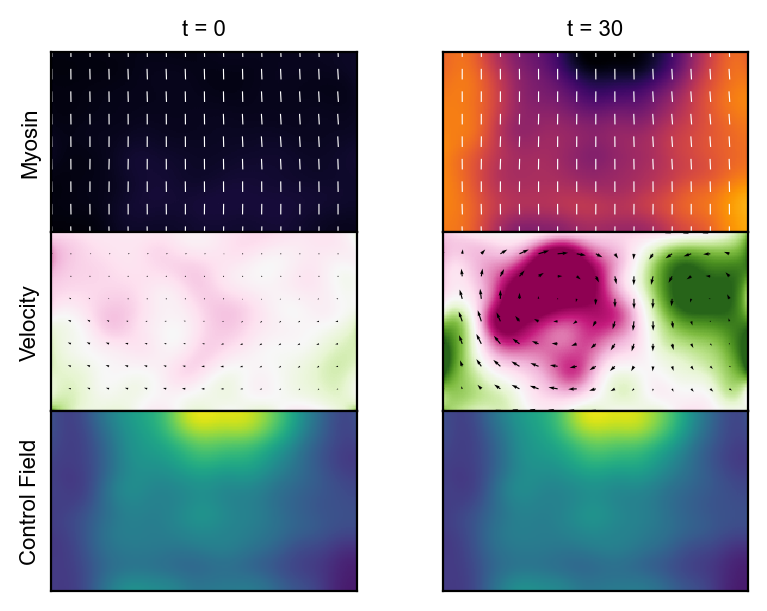

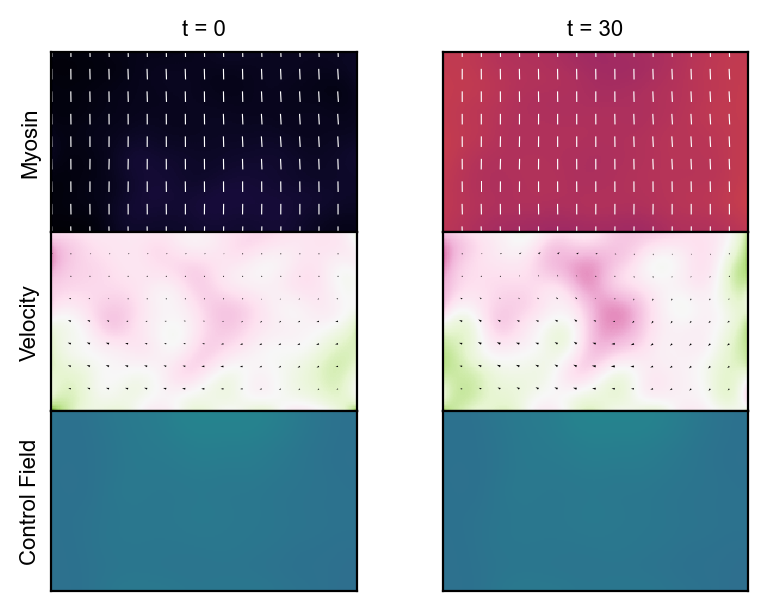

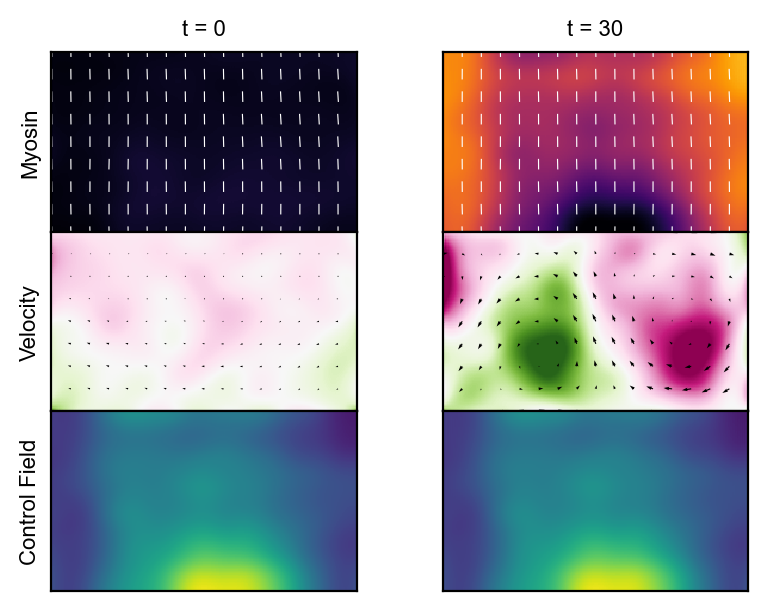

In [20]:
plt.rcParams['font.size'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.frameon'] = False

def get_director_magnitude(mij):
    mij = mij.transpose(2, 3, 0, 1)
    m = np.linalg.norm(mij, axis=(2, 3))
    el, ev = np.linalg.eigh(mij) #Positive eigenvalue is n
    n = ev[..., 1]
    return m, n

slc = slice(1, -2)
skip = 16
tt = [0, 30]
fig1, ax1 = plt.subplots(1, 3, dpi=200, figsize=(6, 1.5), constrained_layout=True)

linestyles=['-', '--', ':']

for jj, name in enumerate(['PatternedControl', 'FlattenedControl', 'ReversedControl']):
    with h5py.File(f'dedalus_runs/{name}/{name}_s3.h5', 'r') as h5f:
        #Collect data
        mij = h5f['tasks/m'][slc]
        vi  = h5f['tasks/v'][slc]
        c   = h5f['tasks/c'][slc]
        t0  = h5f['scales/sim_time'][slc]
        t0 = t0 - t0.min()
        
        x = np.linspace(0, h5f['params/Lx'], mij.shape[-2])
        y = np.linspace(0, h5f['params/Ly'], mij.shape[-1])  
        
        wi = np.gradient(vi[:, 1], x, axis=-2) - np.gradient(vi[:, 0], y, axis=-1)
        print(2*np.std(wi))
        wmax = 0.002
            
        X, Y = np.meshgrid(x.flatten()[::skip], y.flatten()[::skip])
        twargs = dict(pivot='middle', color='white', headwidth=0, headlength=0, headaxislength=0)
        
        w = len(tt) * 2 + 1
        fig2, ax = plt.subplots(3, len(tt), dpi=200, figsize=(w, 3.5))
        for i, ti in enumerate(tt):
            idx = np.argmin(np.abs(t0 - ti))
            mi = mij[idx]
            m, n = get_director_magnitude(mi)
            ax[0, i].set_title(f't = {ti:g}')
            pcM = ax[0, i].pcolormesh(x, y, m.T, cmap='inferno', vmin=0.06, vmax=0.25, rasterized=True)
            ax[0, i].quiver(X, Y, n[::skip, ::skip, 0].T, n[::skip, ::skip, 1].T, **twargs)
            
            v, w = vi[idx], wi[idx]
            pcW = ax[1, i].pcolormesh(x, y, w.T, cmap='PiYG', vmin=-wmax, vmax=wmax, rasterized=True)
            ax[1, i].quiver(X, Y, v[0, ::skip, ::skip].T, v[1, ::skip, ::skip].T, 
                            color="black", scale=3e0)
            
            pcC = ax[2, i].pcolormesh(x, y, c[idx].T, cmap='viridis', vmin=0.8, vmax=1.5, rasterized=True)

        for a in ax.flatten():
            a.set(xticks=[], yticks=[], aspect='equal')
            a.set_ylim([0, a.get_ylim()[1]/2])
        
        ax[0, 0].set_ylabel('Myosin')
        ax[1, 0].set_ylabel('Velocity')
        ax[2, 0].set_ylabel('Control Field')
            
        fig2.subplots_adjust(wspace=0.02, hspace=0)
        fig2.savefig(f'figures/{name}_summary.svg', dpi=200, bbox_inches='tight')

        mnorm = np.linalg.norm(mij, axis=(1,2))
        vnorm = np.linalg.norm(vi, axis=1)

        trm = np.einsum('biiyx->bxy', mij) * 0.5
        dev = np.linalg.norm(mij - trm[:, None, None], axis=(1,2))

        ax1[0].plot(t0, np.mean(dev, axis=(1, 2)), 
                linestyle=linestyles[jj], color='firebrick')
        
        # DV cut through middle of system
        dv_cut = np.mean(mnorm[ti, :, 50:150], axis=-1)
        if jj == 0:
            ax1[1].plot(np.mean(mnorm[0, 64:192, :], axis=-2), color='firebrick', linestyle=linestyles[jj], label='Initial', alpha=0.5)
        ax1[1].plot(np.mean(mnorm[-1, 64:192, :], axis=-2), label=name, color='firebrick', linestyle=linestyles[jj])
        print(mnorm.shape)

        # Tissue flow magnitude
        ax1[2].plot(t0, np.mean(vnorm, axis=(1, 2)), 
                    linestyle=linestyles[jj], color='black', label=name)
        
                
h, l = ax1[2].get_legend_handles_labels()
l = ['Patterned', 'Flat', 'Reversed']
ax1[2].legend(h, l, framealpha=0, 
              title='Control Field',
              loc='center left', bbox_to_anchor=[1, 0.5])

ax1[0].set(
    xlabel='Time',
    ylabel='Anisotropic\nmyosin signal',
    xlim=[0, 30], xticks=[0, 10, 20, 30],
    ylim=[0.05, 0.20], yticks=[0.05, 0.1, 0.15, 0.20]
)
ax1[1].set(
    xlabel='',
    ylabel='Anisotropic\nmyosin signal',
    xlim=[0, 118], xticks=[0, 118], xticklabels=['V', 'D'],
    ylim=[0.05, 0.20], yticks=[0.05, 0.1, 0.15, 0.20]
)
ax1[2].set(
    xlabel='Time',
    ylabel='Mean Flow (A.U.)',
    xlim=[0, 30], xticks=[0, 10, 20, 30],
)

for a in ax1: a.tick_params(which='both', direction='in', width=1.)

fig1.savefig('figures/comparison.svg', dpi=200, bbox_inches='tight')